<h1 align=center> Александр Бибик, студент группы ПИ19-4
<h2 align=center> Тема: "Предварительный анализ данных и построение признаков в задачах распознавания темы текста"
<h3  align=center> Данные взяты с сайта: https://www.kaggle.com/datasets/hetulmehta/website-classification

<h1> Цель работы

Website Classification – общедоступный датасет, содержащий информацию о почти 1500 интернет-ресурсах.
Задача - опредить категорию(тему) ссылки(сайта), зная информацию о ее(его) содержании.

<h1> Работа с исходными данными

Предварительно импортируем все необходимые библиотеки:

In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import time

from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

from collections import defaultdict,Counter
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler

pd.options.mode.chained_assignment = None

<h2> Описательная статистика

Считаем данные:

In [2]:
data=pd.read_csv('D://downloads/website_classification.csv')
data.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


Проведем описательный анализ:

In [3]:
data.shape

(1408, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1408 non-null   int64 
 1   website_url           1408 non-null   object
 2   cleaned_website_text  1408 non-null   object
 3   Category              1408 non-null   object
dtypes: int64(1), object(3)
memory usage: 44.1+ KB


Имеем 1408 наблюдений с 4 признаками (один из которых является целевым). Пустых значений не обнаружено.

Посмотрим на категориальную переменную:

In [5]:
data['Category'].unique()

array(['Travel', 'Social Networking and Messaging', 'News',
       'Streaming Services', 'Sports', 'Photography',
       'Law and Government', 'Health and Fitness', 'Games', 'E-Commerce',
       'Forums', 'Food', 'Education', 'Computers and Technology',
       'Business/Corporate', 'Adult'], dtype=object)

In [6]:
len(data['Category'].unique())

16

Имеем задачу небинарной классификации, так как категорий будет 16.

Посмотрим, каких категорий встречается больше всего:

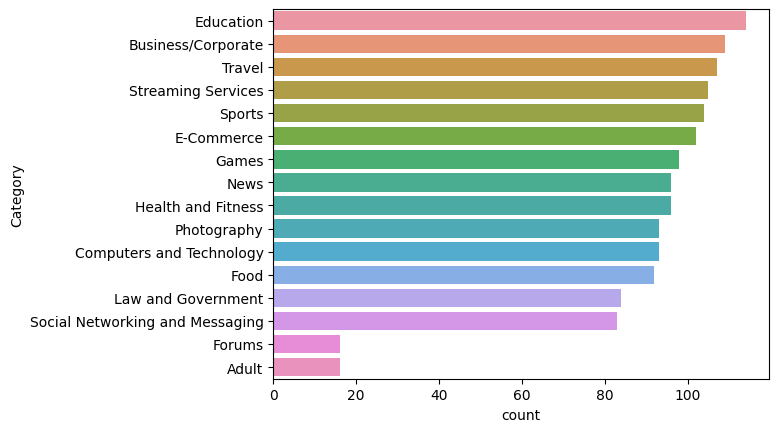

In [8]:
sns.countplot(y=data['Category'],order=data['Category'].value_counts().index[:16])
plt.show()

В целом, среднее количество колеблется от 80-100. "Forums" и "Adult" - исключение. Возможно, в дальнейшем при разбиение придется учесть выравнивание классов. По графику можно увидеть следующий ТОП5-категорий:

1. Educational
2. Business/Corporate
3. Travel
4. Streaming Services
5. Sports

Посмотрим на среднее количество слов в каждой категории:

In [3]:
data['wordCount'] = data['cleaned_website_text'].str.split().str.len()
data.groupby('Category')['wordCount'].mean().nlargest(16)

Category
Adult                              1583.625000
News                               1536.687500
Sports                             1208.980769
Education                           890.307018
Travel                              815.327103
Health and Fitness                  740.687500
Law and Government                  717.226190
Food                                698.097826
E-Commerce                          688.901961
Photography                         605.720430
Computers and Technology            604.462366
Streaming Services                  543.485714
Business/Corporate                  467.844037
Games                               456.132653
Forums                              455.250000
Social Networking and Messaging     313.469880
Name: wordCount, dtype: float64

Заметим, что наибольшее количество слов в среднем наблюдается в категории Adult (в ней наименьшее количество наблюдений).

In [24]:
data.groupby('Category')['wordCount'].sum().nlargest(16)

Category
News                               147522
Sports                             125734
Education                          101495
Travel                              87240
Health and Fitness                  71106
E-Commerce                          70268
Food                                64225
Law and Government                  60247
Streaming Services                  57066
Photography                         56332
Computers and Technology            56215
Business/Corporate                  50995
Games                               44701
Social Networking and Messaging     26018
Adult                               25338
Forums                               7284
Name: wordCount, dtype: int64

Однако общее количество слов отличается в большей степени у категорий News,Sports,Education. Сильно бросается в глаза значение у Forums.

Посмотрим на wordCloud нашего датасета,группируя по тематикам сайтов:

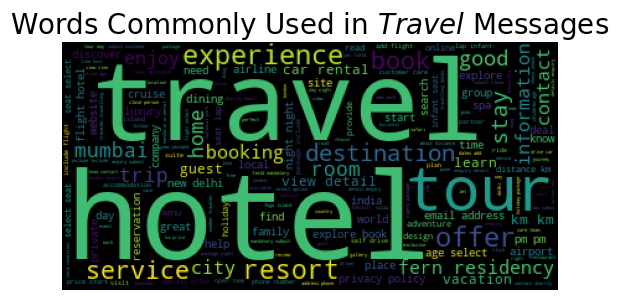

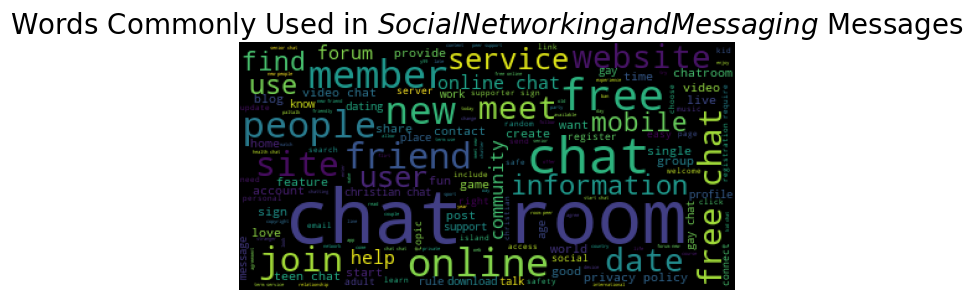

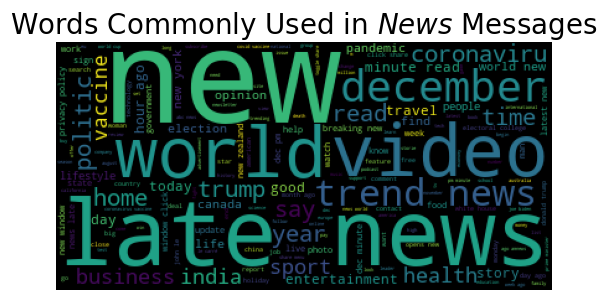

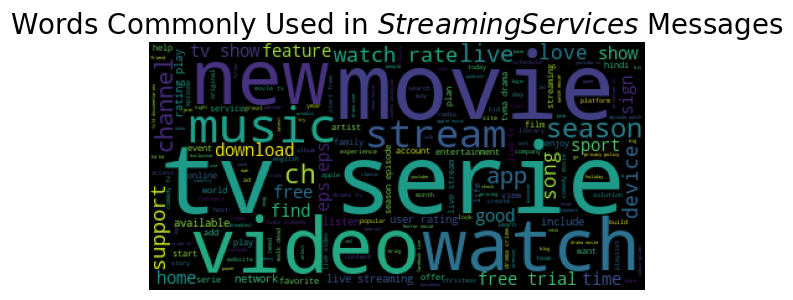

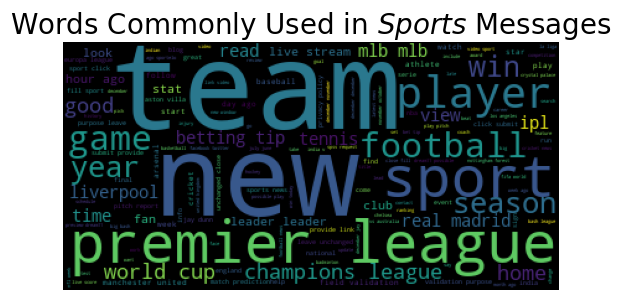

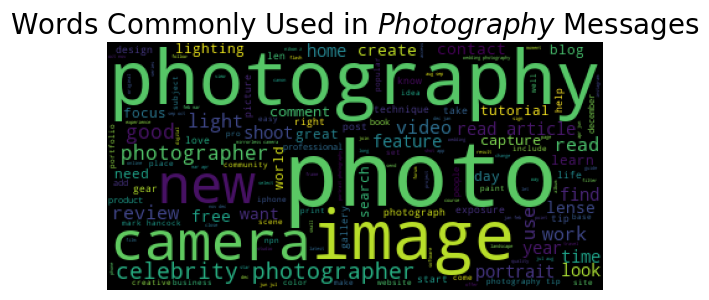

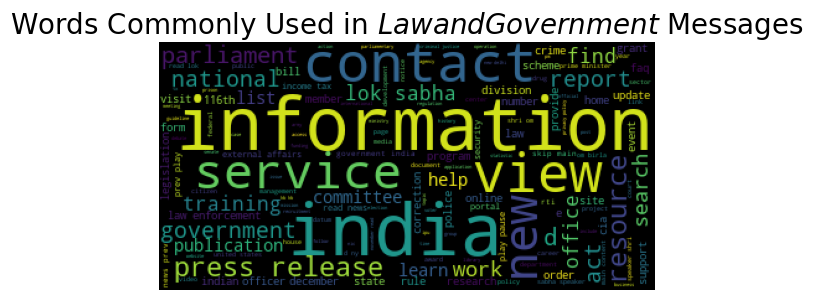

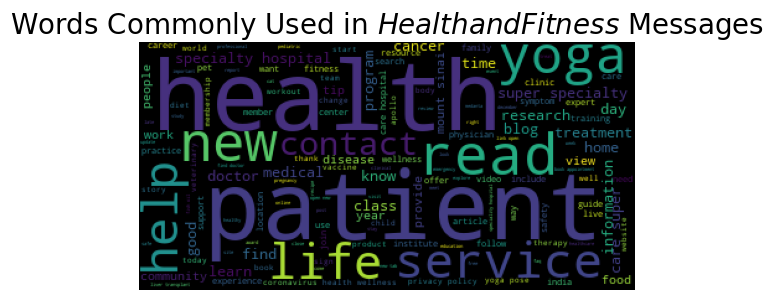

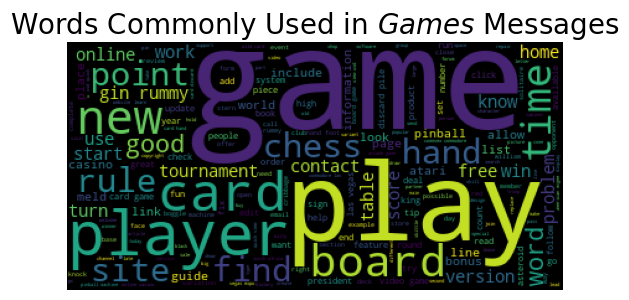

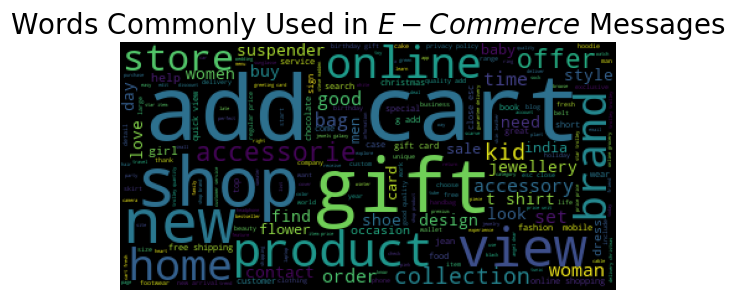

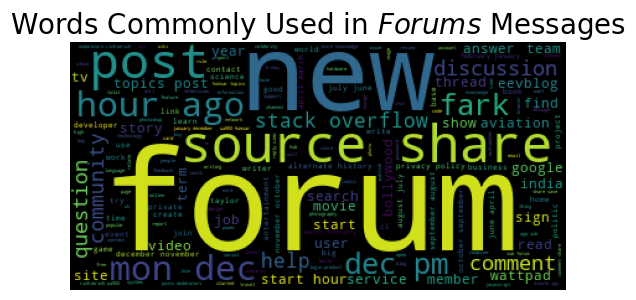

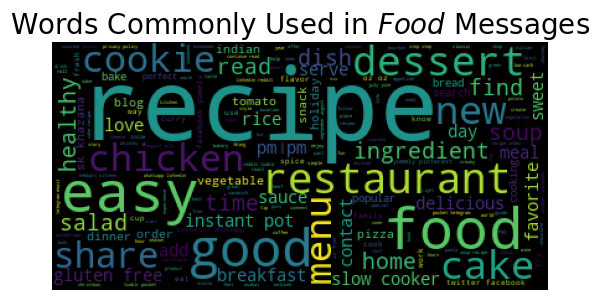

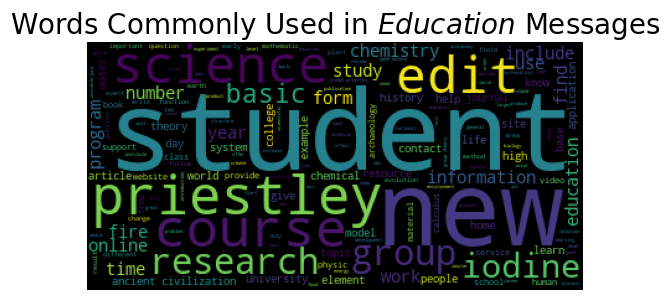

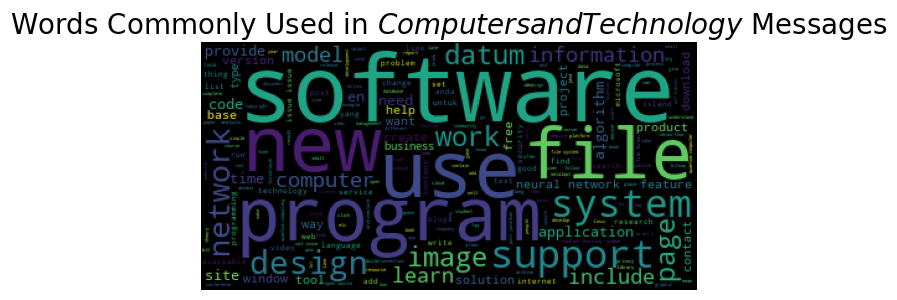

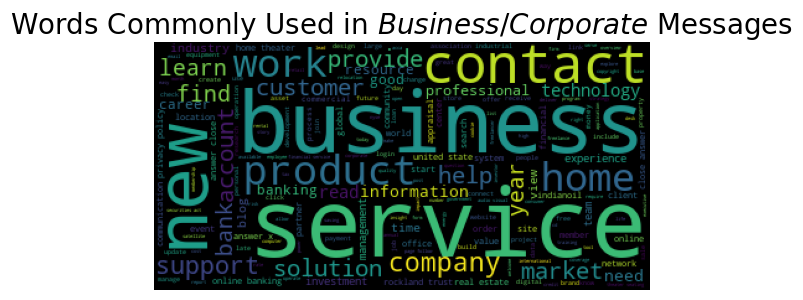

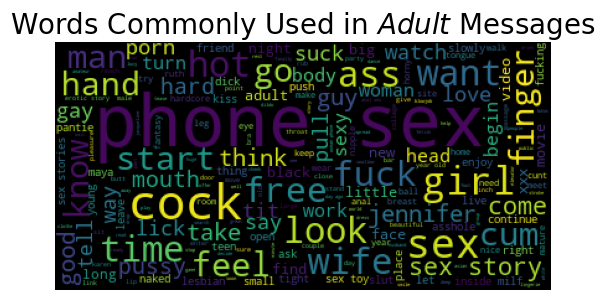

In [28]:
for label in data['Category'].unique().tolist():
    text = data.query('Category == @label')['cleaned_website_text'].str.cat(sep=' ')
    wc = WordCloud()
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Category", size=20)
    plt.show()

Без группировки:

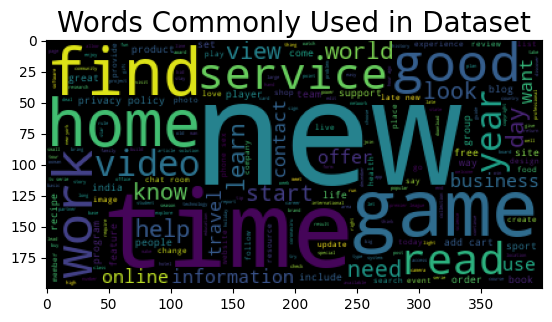

In [3]:
text = data['cleaned_website_text'].str.cat(sep=' ')
wc = WordCloud() 
wc.generate_from_text(text)
plt.imshow(wc)
plt.title(f"Words Commonly Used in Dataset", size=20)
plt.show()

Заметим, что стоп-слов на первый взгляз не видно. Посмотрим на несколько точек данных:

In [75]:
print("Текст: "+data['cleaned_website_text'][0])
print("\n")
print("Категория: "+data['Category'][0])

Текст: official site good hotel accommodation big saving hotel destination worldwide browse hotel review find guarantee good price hotel budget lodging accommodation hotel hotels special offer package special weekend break city break deal budget cheap discount saving select language find deal hotel home try search connect traveller india travel talk community recommend destination flamborough boreland colvend catfield harberton warleggan inspiration trip spot winter wildlife beautiful snowy island bye bye work want spontechnaity tech drive travel vital value maximise travel homes guest love browse property type hotels apartments resorts villa cabins cottage glamping serviced apartment holiday home guest house hostels motels ryokans riads holiday park homestays campsites country house farm stay boats luxury tent self catering accommodation tiny house chapel saint leonards wuqing wuchang saint eval great rowsley instow verified review real guest work start booking follow trip finally rev

In [77]:
print("Текст: "+data['cleaned_website_text'][1000])
print("\n")
print("Категория: "+data['Category'][1000])

Текст: pharmaceutical chemistry journal home pharmaceutical chemistry journal pharmacy pharmacology toxicology organic chemistry year publication monthly pharmaceutical chemistry journal devote scientific technical research creation journal information journal metric late issue late article validation icp ms method determination mercury lead cadmium arsenic medicinal plants related drug preparations authors second synthesis vitro studies o derivative e potent selective antileukemic agents authors synthesis antiaggregant antioxidant activity iso acid salts authors second design synthesis anticancer evaluation new alkylation genistein derivatives authors second biological activity heterocyclic compounds base polyol acetals derivatives authors second author explore subscribe journal xml svg public svg skip main content advertisement search authors editors account pharmaceutical chemistry journal editorial board aims scope year publication monthly pharmaceutical chemistry journal devote sc

Заметим, что в первом примере встречается сразу несколько языков в тексте. Из-за этого могут возникнуть в дальнейшем проблемы, так как датасет рассчитан на работу с английскими символами. Это нужно будет учесть в обработке данных.

<h2> Обработка исходных данных

Необходимо очистить исходную выборку от аномальных значений. Вычислим 1 квантиль и 3 квантиль, чтобы посмотреть на допустимый диапазон по количеству символов, а также по количеству слов:

In [4]:
first_q = np.quantile(data['cleaned_website_text'].str.len(),q=0.25)
third_q = np.quantile(data['cleaned_website_text'].str.len(),q=0.75)
v1,v2 = first_q-1.5*(third_q-first_q),third_q+1.5*(third_q-first_q)

In [41]:
v1,v2

(-6075.625, 13833.375)

In [5]:
first_q = np.quantile(data['cleaned_website_text'].str.split().str.len(),q=0.25)
third_q = np.quantile(data['cleaned_website_text'].str.split().str.len(),q=0.75)
v3,v4 = first_q-1.5*(third_q-first_q),third_q+1.5*(third_q-first_q)

In [42]:
v3,v4

(-859.125, 1953.875)

Необходимо очистить исходную выборку от аномальных значений. 

In [6]:
data['charCount'] = data['cleaned_website_text'].str.len()
cleaned_data = data.drop(data[data['charCount']>v2].index)
cleaned_data.shape

(1301, 6)

In [7]:
cleaned_data = cleaned_data.drop(cleaned_data[cleaned_data['wordCount']>v4].index)
cleaned_data.shape

(1296, 6)

Было очищено 112 значений. Повторно посмотрим на распределения:

In [48]:
cleaned_data.groupby('Category')['wordCount'].mean().nlargest(16)

Category
News                               883.391304
Sports                             878.045455
Travel                             640.696970
Health and Fitness                 593.258427
Law and Government                 577.555556
Education                          530.553398
E-Commerce                         526.821053
Food                               500.174419
Adult                              461.000000
Forums                             455.250000
Photography                        412.795455
Computers and Technology           404.209302
Games                              394.736842
Streaming Services                 392.000000
Business/Corporate                 389.876190
Social Networking and Messaging    282.426829
Name: wordCount, dtype: float64

In [47]:
cleaned_data.groupby('Category')['wordCount'].sum().nlargest(16)

Category
Sports                             77268
Travel                             63429
News                               60954
Education                          54647
Health and Fitness                 52800
E-Commerce                         50048
Law and Government                 46782
Food                               43015
Business/Corporate                 40937
Streaming Services                 39984
Games                              37500
Photography                        36326
Computers and Technology           34762
Social Networking and Messaging    23159
Forums                              7284
Adult                               5532
Name: wordCount, dtype: int64

In [49]:
cleaned_data.groupby('Category')['charCount'].mean().nlargest(16)

Category
News                               6122.681159
Sports                             5943.613636
Travel                             4511.727273
Health and Fitness                 4428.056180
Law and Government                 4402.691358
Education                          4049.106796
E-Commerce                         3610.578947
Food                               3402.313953
Forums                             3162.750000
Photography                        2964.056818
Business/Corporate                 2945.866667
Computers and Technology           2941.860465
Adult                              2895.833333
Streaming Services                 2678.764706
Games                              2664.884211
Social Networking and Messaging    1897.195122
Name: charCount, dtype: float64

Избавимся от первого столбца, который не несет никакой информации:

In [8]:
cleaned_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [22]:
cleaned_data.head()

,website_url,cleaned_website_text,Category,charCount,wordCount
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,4848,672
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,4886,729
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,1969,281
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,9056,1273
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,3449,496


Посмотрим, есть ли в исходной выборке дублирующиеся значения и избавимся от них:

In [9]:
cleaned_data = cleaned_data.drop_duplicates()
cleaned_data.head()

,website_url,cleaned_website_text,Category,wordCount,charCount
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,672,4848
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,729,4886
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,281,1969
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,1273,9056
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,496,3449


In [10]:
cleaned_data.shape

(1276, 5)

Да, в выборке было около 20 дублирующихся строк.

<h1> Преобразование данных

Оставим только нужные признаки:

In [10]:
df = cleaned_data[['website_url','cleaned_website_text','Category']]
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


Преобразуем категориальную переменную в числовую:

In [11]:
df['CategoryId'] = df['Category'].factorize()[0]
df.head()

,website_url,cleaned_website_text,Category,CategoryId
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


<h2> Очистка данных 

Необходимо очистить данные от ненужных символов, а также перевести в нижний регистр - это делается для того, чтобы уменьшить словарь датасета.

In [12]:
def clean_data(row):
    row = "".join(re.sub("(\w+:\/\/\S+)"," ", row))
    row = "".join(re.sub("([^0-9A-Za-z \t'])"," ", row))
    row  = " ".join(row.split()) 
    row = row.strip()
    row = row.lower()
    
    return row

In [13]:
%%time

df['cleaned_website_text_2'] = df['cleaned_website_text'].apply(lambda x: clean_data(x))
df

Wall time: 499 ms


,website_url,cleaned_website_text,Category,CategoryId,cleaned_website_text_2
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0,official site good hotel accommodation big sav...
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0,expedia hotel book sites like use vacation wor...
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0,tripadvisor hotel book sites like previously d...
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0,cheap flights search compare flights momondo f...
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0,bot create free account create free account si...
...,...,...,...,...,...
1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult,15,old nude women porn mature granny sex horny ol...
1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,15,bdsm cams bdsm chat bondage cams free bdsm vid...
1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult,15,porno dvd online european porn dvd cheap adult...
1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult,15,anal dream house anal dream house anal dream h...


In [98]:
for i in df[df['cleaned_website_text_2']!=df['cleaned_website_text']][['cleaned_website_text_2','cleaned_website_text']][:1].values:
    print("До очистки: ",i[1])
    print('\n')
    print("После очистки: ",i[0])


До очистки:  official site good hotel accommodation big saving hotel destination worldwide browse hotel review find guarantee good price hotel budget lodging accommodation hotel hotels special offer package special weekend break city break deal budget cheap discount saving select language find deal hotel home try search connect traveller india travel talk community recommend destination flamborough boreland colvend catfield harberton warleggan inspiration trip spot winter wildlife beautiful snowy island bye bye work want spontechnaity tech drive travel vital value maximise travel homes guest love browse property type hotels apartments resorts villa cabins cottage glamping serviced apartment holiday home guest house hostels motels ryokans riads holiday park homestays campsites country house farm stay boats luxury tent self catering accommodation tiny house chapel saint leonards wuqing wuchang saint eval great rowsley instow verified review real guest work start booking follow trip final

Отлично, теперь можно приступить к токенизации и приведениям слов к словоформам.

Посмотрим на частовстречающие слова в датасете еще раз. Убедимся, что очистка от стоп-слов будет не обязательна. Вероятно, автор датасета заранее позаботился об этом.

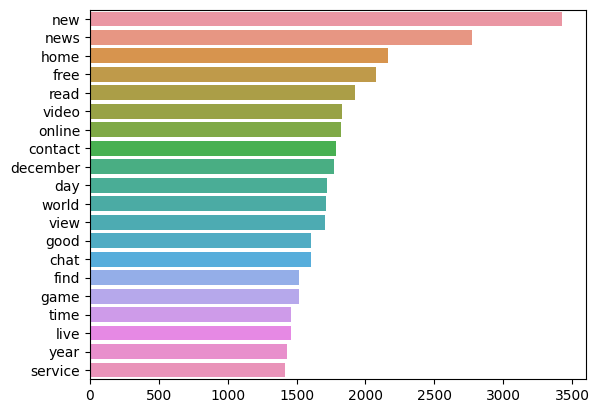

In [96]:
counter=Counter(" ".join(df['cleaned_website_text_2']).split()).most_common(20)
x=[]
y=[]
for word,count in counter:
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.show() 

<h2> Токенизация

In [14]:
%%time

df['tokenized_words'] = df['cleaned_website_text_2'].apply(lambda x:word_tokenize(x))
df.head()

Wall time: 2.97 s


,website_url,cleaned_website_text,Category,CategoryId,cleaned_website_text_2,tokenized_words
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0,official site good hotel accommodation big sav...,"[official, site, good, hotel, accommodation, b..."
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0,expedia hotel book sites like use vacation wor...,"[expedia, hotel, book, sites, like, use, vacat..."
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0,tripadvisor hotel book sites like previously d...,"[tripadvisor, hotel, book, sites, like, previo..."
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0,cheap flights search compare flights momondo f...,"[cheap, flights, search, compare, flights, mom..."
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0,bot create free account create free account si...,"[bot, create, free, account, create, free, acc..."


Удалим стоп-слова, если такие присутствуют(необязательный пункт):

In [15]:
%%time

def removeStopWords(value):
    return [word for word in value if word not in stopwords.words('english')] 
df['tokenized_words'] = df['tokenized_words'].apply(removeStopWords)

Wall time: 3min 16s


Попробуем привести слова к словоформам. Можно использовать как стемминг, так и лемматизацию - в дальнейшем сравнить. Сперва воспользуемся лемматизацией.

In [16]:
wordnetlemmatizer= WordNetLemmatizer()
df['tokenized_words']=df['tokenized_words'].apply(lambda x:[wordnetlemmatizer.lemmatize(i) for i in x])
df.head()

,website_url,cleaned_website_text,Category,CategoryId,cleaned_website_text_2,tokenized_words
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0,official site good hotel accommodation big sav...,"[official, site, good, hotel, accommodation, b..."
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0,expedia hotel book sites like use vacation wor...,"[expedia, hotel, book, site, like, use, vacati..."
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0,tripadvisor hotel book sites like previously d...,"[tripadvisor, hotel, book, site, like, previou..."
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0,cheap flights search compare flights momondo f...,"[cheap, flight, search, compare, flight, momon..."
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0,bot create free account create free account si...,"[bot, create, free, account, create, free, acc..."


In [131]:
stemmer = SnowballStemmer("english")
df['tokenized_words']=df['tokenized_words'].apply(lambda x:[stemmer.stem(i) for i in x])
df.head()

,website_url,cleaned_website_text,Category,CategoryId,cleaned_website_text_2,tokenized_words,final_text
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0,official site good hotel accommodation big sav...,"[offici, site, good, hotel, accommod, big, sav...",official site good hotel accommodation big sav...
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0,expedia hotel book sites like use vacation wor...,"[expedia, hotel, book, site, like, use, vacat,...",expedia hotel book sites like use vacation wor...
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0,tripadvisor hotel book sites like previously d...,"[tripadvisor, hotel, book, site, like, previou...",tripadvisor hotel book sites like previously d...
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0,cheap flights search compare flights momondo f...,"[cheap, flight, search, compar, flight, momond...",cheap flights search compare flights momondo f...
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0,bot create free account create free account si...,"[bot, creat, free, account, creat, free, accou...",bot create free account create free account si...


In [17]:
df['final_text'] = df['tokenized_words'].apply(lambda x:' '.join(x))
df

,website_url,cleaned_website_text,Category,CategoryId,cleaned_website_text_2,tokenized_words,final_text
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0,official site good hotel accommodation big sav...,"[official, site, good, hotel, accommodation, b...",official site good hotel accommodation big sav...
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0,expedia hotel book sites like use vacation wor...,"[expedia, hotel, book, site, like, use, vacati...",expedia hotel book site like use vacation work...
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0,tripadvisor hotel book sites like previously d...,"[tripadvisor, hotel, book, site, like, previou...",tripadvisor hotel book site like previously de...
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0,cheap flights search compare flights momondo f...,"[cheap, flight, search, compare, flight, momon...",cheap flight search compare flight momondo fin...
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0,bot create free account create free account si...,"[bot, create, free, account, create, free, acc...",bot create free account create free account si...
...,...,...,...,...,...,...,...
1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult,15,old nude women porn mature granny sex horny ol...,"[old, nude, woman, porn, mature, granny, sex, ...",old nude woman porn mature granny sex horny ol...
1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,15,bdsm cams bdsm chat bondage cams free bdsm vid...,"[bdsm, cam, bdsm, chat, bondage, cam, free, bd...",bdsm cam bdsm chat bondage cam free bdsm video...
1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult,15,porno dvd online european porn dvd cheap adult...,"[porno, dvd, online, european, porn, dvd, chea...",porno dvd online european porn dvd cheap adult...
1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult,15,anal dream house anal dream house anal dream h...,"[anal, dream, house, anal, dream, house, anal,...",anal dream house anal dream house anal dream h...


<h1> Обучение без учителя

Попробуем провести обучение без учителя, используя кластеризацию с количеством кластеров, равному количеству категорий (16).
Возможно, это позволит нам увидеть неочевидные зависимости. Также на данном этапе воспользуемся известным способом векторизации CountVectorizer(мешок слов).

In [24]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df['final_text'])
vectors

<1276x39673 sparse matrix of type '<class 'numpy.int64'>'
	with 283093 stored elements in Compressed Sparse Row format>

In [35]:
%%time

n_clusters = 16
n_words = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
kmeans.fit(vectors)

labels = {k:[] for k in range (n_clusters)}
for i, label in enumerate(kmeans.labels_):
    labels[label].append(i)

text_clusters = {k:"" for k in range (n_clusters)}
for k in range(n_clusters):
    text_clusters[k] = ' '.join(df['final_text'].iloc[labels[k]])
    
for k, text in text_clusters.items():
    print(f"{n_words} наиболее встречаемых слов в кластере {k}:  {Counter(text.split()).most_common(n_words)}")


5 наиболее встречаемых слов в кластере 0:  [('news', 1150), ('december', 882), ('ago', 683), ('league', 672), ('sport', 580)]
5 наиболее встречаемых слов в кластере 1:  [('lesson', 294), ('light', 67), ('moon', 46), ('law', 46), ('sun', 45)]
5 наиболее встречаемых слов в кластере 2:  [('sabha', 91), ('shri', 82), ('lok', 81), ('speaker', 66), ('parliament', 63)]
5 наиболее встречаемых слов в кластере 3:  [('card', 523), ('game', 387), ('play', 258), ('player', 238), ('gin', 135)]
5 наиболее встречаемых слов в кластере 4:  [('apple', 132), ('music', 73), ('include', 65), ('itunes', 49), ('menu', 44)]
5 наиболее встречаемых слов в кластере 5:  [('new', 2557), ('service', 1899), ('home', 1858), ('free', 1776), ('contact', 1654)]
5 наиболее встречаемых слов в кластере 6:  [('watch', 162), ('rate', 150), ('episode', 57), ('season', 48), ('drama', 42)]
5 наиболее встречаемых слов в кластере 7:  [('new', 192), ('open', 191), ('click', 190), ('window', 190), ('share', 182)]
5 наиболее встречае

In [34]:
df['Category'].unique()

array(['Travel', 'Social Networking and Messaging', 'News',
       'Streaming Services', 'Sports', 'Photography',
       'Law and Government', 'Health and Fitness', 'Games', 'E-Commerce',
       'Forums', 'Food', 'Education', 'Computers and Technology',
       'Business/Corporate', 'Adult'], dtype=object)

Заметим, что метод K-средних нам ничего не дал. Вероятно, это связано с тем, что для поиска зависимостей темы категорий необходим более глубокий анализ взаимосвязи между токенами(однако некоторые кластеры, судя по топ5 словам, определены верно, например, кластер 13 очень похож на категорию Social Networking and Messaging). В целом, тематики перемешались. Приступим к обучению с учителем, используя разменные данные.

<h1> Разбиение данных

В качестве целевой переменной возьмем идентификатор категории, а в качестве признаков - обработанный текст.

In [50]:
X = df['final_text']
y = df['CategoryId']

Разбиение будет случайным, так как за счет этого можно получить наилучшие показатели модели, ведь при последовательном разбиении есть вероятность неупорядоченных данных.
Разбиение временных рядов в данном случае будет непременимо.

In [51]:
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=0,stratify=y)

Разумеется, для того, чтобы модель обучилась, необходимо преобразовать текстовые переменные в числовые. Это и делает векторизация.

In [52]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

<h1> Обучение с учителем

Попробуем обучить и протестировать несколько моделей, улучшив самую перспективную. Так как основная задача работы - это обработка текста, то остановимся на следующих моделях:
1. MultinomialNB()
2. Logistic Regression()
3. KNeighborsClassifier()
4. LinearSVC()
5. SVC()
6. RandomForestClassifier()
7. DecisionTreeClassifier()

In [30]:
%%time

mnb_clf= MultinomialNB()
mnb_clf.fit(X_train_cv,y_train)
mnb_res = mnb_clf.predict(X_test_cv)
print('\tClassification Report for MultinomialNB():\n\n',classification_report(y_test,mnb_res,zero_division=True))

	Classification Report for MultinomialNB():

               precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       0.94      0.75      0.83        20
           2       0.88      0.82      0.85        17
           3       0.89      1.00      0.94        25
           4       0.91      0.95      0.93        21
           5       0.91      0.95      0.93        22
           6       0.91      1.00      0.95        20
           7       0.87      1.00      0.93        20
           8       0.96      1.00      0.98        24
           9       1.00      0.96      0.98        24
          10       1.00      0.00      0.00         4
          11       1.00      0.95      0.98        21
          12       0.88      0.88      0.88        26
          13       0.83      0.71      0.77        21
          14       0.78      0.81      0.79        26
          15       1.00      0.67      0.80         3

    accuracy                      

Модель показала неплохие результаты во многих категориях, однако обратим внимание на Forums - у нее полнота равна 0. В целом, качество модели очень хорошее. Затраченное время минимально.

In [69]:
%%time

lr_clf= LogisticRegression(max_iter=10000)
lr_clf.fit(X_train_cv,y_train)
lr_res = lr_clf.predict(X_test_cv)
print('\tClassification Report for Logistic Regression():\n\n',classification_report(y_test,lr_res,zero_division=True))

	Classification Report for Logistic Regression():

                                  precision    recall  f1-score   support

                          Adult       1.00      0.33      0.50         3
             Business/Corporate       0.78      0.81      0.79        26
       Computers and Technology       0.76      0.90      0.83        21
                     E-Commerce       0.92      0.92      0.92        24
                      Education       0.84      0.81      0.82        26
                           Food       0.91      0.95      0.93        21
                         Forums       1.00      0.50      0.67         4
                          Games       0.92      0.96      0.94        24
             Health and Fitness       0.89      0.85      0.87        20
             Law and Government       0.95      0.90      0.92        20
                           News       0.80      0.71      0.75        17
                    Photography       0.94      0.77      0.85        2

Логистическая регрессия неплохо справилась со многими категориями, хуже всего - с категорией Adult (по метрике полноты). 

In [70]:
%%time

knn_clf= KNeighborsClassifier()
knn_clf.fit(X_train_cv,y_train)
knn_res = knn_clf.predict(X_test_cv)
print('\tClassification Report for KNeighborsClassifier():\n\n',classification_report(y_test,knn_res,zero_division=True))

	Classification Report for KNeighborsClassifier():

                                  precision    recall  f1-score   support

                          Adult       1.00      0.33      0.50         3
             Business/Corporate       0.43      0.35      0.38        26
       Computers and Technology       0.38      0.43      0.40        21
                     E-Commerce       0.76      0.54      0.63        24
                      Education       0.78      0.27      0.40        26
                           Food       0.65      0.52      0.58        21
                         Forums       0.20      0.25      0.22         4
                          Games       0.64      0.67      0.65        24
             Health and Fitness       1.00      0.35      0.52        20
             Law and Government       1.00      0.40      0.57        20
                           News       0.80      0.24      0.36        17
                    Photography       0.82      0.41      0.55        

Метод ближайших соседей показал плохую точность при предсказании результатов, однако справился быстро, так как модель простейшая.

In [71]:
%%time

lsvc_clf= LinearSVC()
lsvc_clf.fit(X_train_cv,y_train)
lsvc_res = lsvc_clf.predict(X_test_cv)
print('\tClassification Report for LinearSVC():\n\n',classification_report(y_test,lsvc_res,zero_division=True))

	Classification Report for LinearSVC():

                                  precision    recall  f1-score   support

                          Adult       1.00      0.67      0.80         3
             Business/Corporate       0.83      0.73      0.78        26
       Computers and Technology       0.72      0.86      0.78        21
                     E-Commerce       0.88      0.92      0.90        24
                      Education       0.78      0.69      0.73        26
                           Food       0.87      0.95      0.91        21
                         Forums       0.67      0.50      0.57         4
                          Games       0.85      0.96      0.90        24
             Health and Fitness       0.89      0.80      0.84        20
             Law and Government       0.94      0.80      0.86        20
                           News       0.73      0.65      0.69        17
                    Photography       0.86      0.82      0.84        22
Social N

Посмотрим на метод опорных векторов (линейное ядро). Хоть точность модели и равна 0.82, однако не будем опираться на эту метрику. Взглянем подробнее на каждый класс. Можно заметить, что хуже всего удалось поработать с категорией Forums. Как уже было упомянуто, это могло быть связано с тем, что данных для обучения в данной категории недостаточно.

In [75]:
%%time

svc_clf= SVC()
svc_clf.fit(X_train_cv,y_train)
svc_res = svc_clf.predict(X_test_cv)
print('\tClassification Report for SVC():\n\n',classification_report(y_test,svc_res,zero_division=True))

	Classification Report for SVC():

                                  precision    recall  f1-score   support

                          Adult       1.00      0.00      0.00         3
             Business/Corporate       0.21      0.85      0.34        26
       Computers and Technology       1.00      0.48      0.65        21
                     E-Commerce       0.92      0.46      0.61        24
                      Education       0.95      0.73      0.83        26
                           Food       1.00      0.57      0.73        21
                         Forums       1.00      0.00      0.00         4
                          Games       0.93      0.54      0.68        24
             Health and Fitness       1.00      0.65      0.79        20
             Law and Government       0.93      0.65      0.76        20
                           News       0.86      0.71      0.77        17
                    Photography       1.00      0.41      0.58        22
Social Network

SVC с rbf ядром показало результаты значительно хуже, чем с линейным. Можно обратить внимание на нулевую полноту в нескольких классах, а также плохую точность в Business/Corporate и Sports.

In [74]:
%%time

rf_clf= RandomForestClassifier()
rf_clf.fit(X_train_cv,y_train)
rf_res = rf_clf.predict(X_test_cv)
print('\tClassification Report for RandomForestClassifier():\n\n',classification_report(y_test,rf_res,zero_division=True))

	Classification Report for RandomForestClassifier():

                                  precision    recall  f1-score   support

                          Adult       1.00      0.00      0.00         3
             Business/Corporate       0.71      0.65      0.68        26
       Computers and Technology       0.80      0.76      0.78        21
                     E-Commerce       0.85      0.92      0.88        24
                      Education       0.81      0.81      0.81        26
                           Food       0.87      0.95      0.91        21
                         Forums       1.00      0.00      0.00         4
                          Games       0.91      0.88      0.89        24
             Health and Fitness       0.94      0.75      0.83        20
             Law and Government       0.79      0.95      0.86        20
                           News       0.80      0.71      0.75        17
                    Photography       0.90      0.86      0.88      

RandomForestClassifier() в целом показал неплохие результаты за секунду. Однако, опять же, для категорий Adult и Forums полнота нулевая - классификатор не смог обнаружить ни одного такого объекта.

In [76]:
%%time

dt_clf= DecisionTreeClassifier()
dt_clf.fit(X_train_cv,y_train)
dt_res = dt_clf.predict(X_test_cv)
print('\tClassification Report for DecisionTreeClassifier():\n\n',classification_report(y_test,dt_res,zero_division=True))

	Classification Report for DecisionTreeClassifier():

                                  precision    recall  f1-score   support

                          Adult       0.00      0.00      0.00         3
             Business/Corporate       0.35      0.35      0.35        26
       Computers and Technology       0.39      0.52      0.45        21
                     E-Commerce       0.55      0.67      0.60        24
                      Education       0.33      0.19      0.24        26
                           Food       0.64      0.67      0.65        21
                         Forums       0.00      0.00      0.00         4
                          Games       0.61      0.79      0.69        24
             Health and Fitness       0.48      0.50      0.49        20
             Law and Government       0.65      0.65      0.65        20
                           News       0.71      0.29      0.42        17
                    Photography       0.85      0.77      0.81      

DecisionTreeClassifier() обучился быстро, однако не очень хорошо. Не говоря о типичной проблеме с Adult и Forums(как у других моделей), другие категории по метрикам precision/recall тоже имеют слабые результаты (меньше 0.5)

<h1> Выбор перспективной модели

Среди созданных и протестированных выше моделей наилучшие результаты показал MultinomialNB(). Попробуем улучшить модель.

<h1> Улучшение перспективной модели

Попробуем искуственно сбалансировать наши классы, так как основной проблемой модели было недообучение в рамках Forums:

In [53]:
oversample = RandomOverSampler()
X_train_cv,y_train = oversample.fit_resample(X_train_cv,y_train)

In [81]:
y_train.value_counts()

Streaming Services                 78
Health and Fitness                 78
E-Commerce                         78
Photography                        78
Education                          78
Law and Government                 78
Games                              78
Computers and Technology           78
Travel                             78
Food                               78
Social Networking and Messaging    78
Business/Corporate                 78
News                               78
Sports                             78
Adult                              78
Forums                             78
Name: Category, dtype: int64

In [54]:
%%time

mnb_clf= MultinomialNB()
mnb_clf.fit(X_train_cv,y_train)
mnb_res = mnb_clf.predict(X_test_cv)
print('\tClassification Report for MultinomialNB():\n\n',classification_report(y_test,mnb_res,zero_division=True))

	Classification Report for MultinomialNB():

               precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.85      0.92        20
           2       0.82      0.82      0.82        17
           3       0.96      1.00      0.98        25
           4       0.91      0.95      0.93        21
           5       0.95      0.95      0.95        22
           6       0.91      1.00      0.95        20
           7       0.87      1.00      0.93        20
           8       1.00      0.96      0.98        24
           9       1.00      0.96      0.98        24
          10       1.00      0.25      0.40         4
          11       1.00      0.95      0.98        21
          12       0.88      0.88      0.88        26
          13       0.86      0.86      0.86        21
          14       0.81      0.81      0.81        26
          15       1.00      0.67      0.80         3

    accuracy                      

Отлично, результат стал намного выше - однако полнота Forums все равно на невысоком уровне.

Попробуем изменить размеры обучающих и тестовых выборок к соотношению 90%/10%:

In [104]:
%%time

mnb_clf= MultinomialNB()
mnb_clf.fit(X_train_cv,y_train)
mnb_res = mnb_clf.predict(X_test_cv)
print('\tClassification Report for MultinomialNB():\n\n',classification_report(y_test,mnb_res,zero_division=True))

	Classification Report for MultinomialNB():

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.75      0.86         8
           2       0.86      0.86      0.86         7
           3       0.83      1.00      0.91        10
           4       1.00      0.88      0.93         8
           5       0.90      1.00      0.95         9
           6       0.80      1.00      0.89         8
           7       1.00      1.00      1.00         8
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00         9
          10       1.00      0.00      0.00         2
          11       1.00      1.00      1.00         9
          12       0.88      0.70      0.78        10
          13       0.80      0.89      0.84         9
          14       0.75      0.90      0.82        10
          15       1.00      1.00      1.00         1

    accuracy                      

Модель стала переобучаться. Стоит использовать прежнее соотношение.

Попробуем изменить первоначальную обработку. Используем токенизацию без лемм:

In [130]:
%%time

mnb_clf= MultinomialNB()
mnb_clf.fit(X_train_cv,y_train)
mnb_res = mnb_clf.predict(X_test_cv)
print('\tClassification Report for MultinomialNB():\n\n',classification_report(y_test,mnb_res,zero_division=True))

	Classification Report for MultinomialNB():

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.75      0.86         8
           2       0.67      0.86      0.75         7
           3       0.91      1.00      0.95        10
           4       0.88      0.88      0.88         8
           5       1.00      1.00      1.00         9
           6       0.80      1.00      0.89         8
           7       1.00      1.00      1.00         8
           8       1.00      0.80      0.89        10
           9       0.90      1.00      0.95         9
          10       1.00      0.00      0.00         2
          11       1.00      1.00      1.00         9
          12       0.88      0.70      0.78        10
          13       0.78      0.78      0.78         9
          14       0.75      0.90      0.82        10
          15       1.00      1.00      1.00         1

    accuracy                      

Результат стал явно хуже. Попробуем использовать стемминг:

In [136]:
%%time

mnb_clf= MultinomialNB()
mnb_clf.fit(X_train_cv,y_train)
mnb_res = mnb_clf.predict(X_test_cv)
print('\tClassification Report for MultinomialNB():\n\n',classification_report(y_test,mnb_res,zero_division=True))

	Classification Report for MultinomialNB():

               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.62      0.77         8
           2       0.60      0.86      0.71         7
           3       0.83      1.00      0.91        10
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00         9
           6       0.80      1.00      0.89         8
           7       0.89      1.00      0.94         8
           8       1.00      0.80      0.89        10
           9       1.00      1.00      1.00         9
          10       1.00      0.00      0.00         2
          11       1.00      1.00      1.00         9
          12       0.88      0.70      0.78        10
          13       0.89      0.89      0.89         9
          14       0.82      0.90      0.86        10
          15       1.00      1.00      1.00         1

    accuracy                      

Получается, для наших данных в идеале подходит лемматизация. Также отметим, что использование TF-IDF в качестве метода векторизации дало результаты хуже.

Напоследок проведем GridSearchCV для поиска наилучших параметров:

In [64]:
parameters = {  
'alpha': (1, 0.1, 0.3, 0.5, 0.01, 0.001, 0.0001, 0.00001)  
}  

mnb = MultinomialNB()

grid = GridSearchCV(mnb, parameters,scoring = 'accuracy')
grid.fit(X_train_cv, y_train)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.9343036144578314
{'alpha': 0.3}
MultinomialNB(alpha=0.3)


In [69]:
%%time

mnb_clf= MultinomialNB(alpha=0.3)
mnb_clf.fit(X_train_cv,y_train)
mnb_res = mnb_clf.predict(X_test_cv)
print('\tClassification Report for best MultinomialNB():\n\n',classification_report(y_test,mnb_res,zero_division=True))

	Classification Report for best MultinomialNB():

               precision    recall  f1-score   support

           0       0.93      1.00      0.96        25
           1       1.00      0.95      0.97        20
           2       0.88      0.82      0.85        17
           3       0.96      1.00      0.98        25
           4       0.95      0.95      0.95        21
           5       0.95      0.95      0.95        22
           6       0.91      1.00      0.95        20
           7       0.87      1.00      0.93        20
           8       1.00      1.00      1.00        24
           9       1.00      0.96      0.98        24
          10       1.00      0.25      0.40         4
          11       1.00      1.00      1.00        21
          12       0.92      0.88      0.90        26
          13       0.86      0.86      0.86        21
          14       0.81      0.81      0.81        26
          15       1.00      0.67      0.80         3

    accuracy                 

Уменьшение параметра alpha с 1 до 0.3 дало прирост во многих категориях. Итоговая модель получилась очень хорошего качества.

Матрица ошибок:

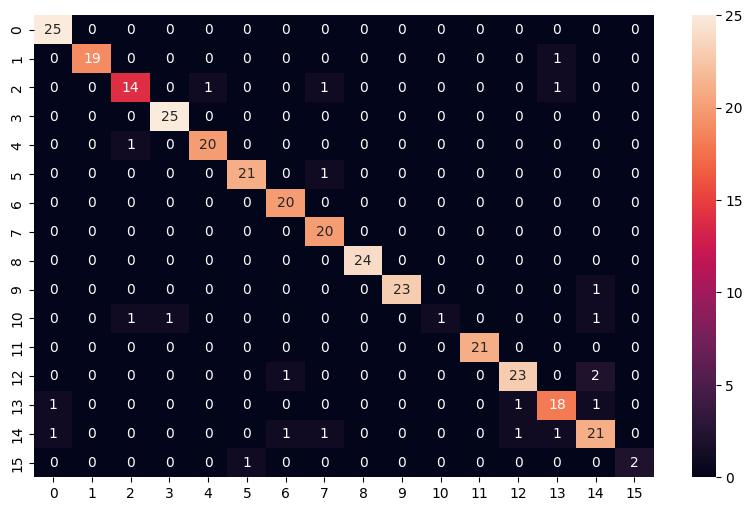

In [73]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,mnb_res),annot=True)
plt.show()

In [75]:
print(accuracy_score(y_test,mnb_res))

0.9310344827586207


<h1> Заключение

В процессе проделанной работы удалось определить тему сайта, зная его содержание. Обучив несколько моделей, была выбрана перспективная для последующего улучшения. По итогу прирост удалось получить в среднем на 3%, благодаря изменению обработки данных. Также мне удалось сделать следующие выводы:
1. NLP можно использовать для обработки текста и разработки функций, которые будут использоваться при построении моделей ML.
2. Алгоритм полиномиального наивного Байеса можно использовать для выполнения многоклассовой классификации с большим количеством классов.
3. Наивный Байес в целом может довольно легко обрабатывать большое количество функций по сравнению с размером данных.
4. Для будущей работы мы можем увеличить количество записей данных для классов с меньшей частотой и, следовательно, еще больше улучшить модель(например, Forums)